In [1]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


# Data preprocessing and parameters

In [3]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size

x_train = x_train.astype('float32') / 255. # Nawid - Divides the values by 255
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) # Nawid - Reshapes the values
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


# network parameters
input_shape = (original_dim, )
intermediate_dim = 64
batch_size = 128
latent_dim = 32
epochs = 5

# Encoder architecture

In [4]:
class Sampling(tf.keras.layers.Layer): # Nawid - Specifies a custom layer
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_sigma = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # Nawid - Initalised random values with a mean of 0 and a standard deviation of 1
    return z_mean + tf.exp(0.5 * z_log_sigma) * epsilon

In [5]:
class Encoder(tf.keras.layers.Layer): # Nawid - This defines the layer for the encoder
  def __init__(self, latent_dim=32, intermediate_dim = 64):
    super(Encoder, self).__init__()
    self.Dense1 = tf.keras.layers.Dense(intermediate_dim, activation='relu')
    self.Dense_mean = tf.keras.layers.Dense(latent_dim)
    self.Dense_log_var = tf.keras.layers.Dense(latent_dim)
    self.sampling = Sampling() # Nawid-  This instantiates the sampling layer for the encoder

  def call(self,inputs):
    x1 = self.Dense1(inputs)
    z_mean = self.Dense_mean(x1)
    z_log_var = self.Dense_log_var(x1)
    z = self.sampling((z_mean, z_log_var))
    return z_mean,z_log_var, z



# Decoder architecture

In [6]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,latent_dim=32, intermediate_dim=64):
    super(Decoder,self).__init__()
    self.Dense_intermediate = tf.keras.layers.Dense(intermediate_dim, activation='relu')
    self.Dense_reconstruct = tf.keras.layers.Dense(original_dim, activation ='sigmoid')

  def call(self, inputs):
    x1 = self.Dense_intermediate(inputs)
    x_reconstruct = self.Dense_reconstruct(x1)
    return x_reconstruct


# VAE instantiation

In [7]:
x = tf.keras.layers.Input(shape=(original_dim)) # instantiates the input layer
z_mean,z_log_var, z = Encoder()((x))
output = Decoder()((z))

encoder_model = tf.keras.Model(x,z)
encoder_model.summary()

vae =tf.keras.Model(x, output)
vae.summary()

decoder_input = tf.keras.layers.Input(shape=(latent_dim))
decoder_layer = vae.layers[-1]
decoder_output = decoder_layer(decoder_input)

decoder_model = tf.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
encoder (Encoder)            ((None, 32), (None, 32),  54400     
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
encoder (Encoder)            ((None, 32), (None, 32),  54400     
_________________________________________________________________
decoder (Decoder)            (None, 784)               53072     
Total params: 107,472
Trainable params: 

In [8]:
def vae_loss(x, x_decoded_mean):
    xent_loss = tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
    xent_loss *= original_dim
    #xent_loss = tf.keras.backend.mean(xent_loss)
    kl_loss = - 0.5 * tf.keras.backend.mean(1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss,experimental_run_tf_function=False)
 # Explanation for where experimental_run_tf comes from -  https://github.com/tensorflow/probability/issues/519 

#vae.compile(optimizer='adam', loss='binary_crossentropy', experimental_run_tf_function=False)

In [9]:
vae.fit(x_train_noisy, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 45us/sample - loss: 179.6368 - val_loss: 139.0813
Epoch 2/5
60000/60000 [==============================] - 2s 35us/sample - loss: 130.5024 - val_loss: 123.1167
Epoch 3/5
60000/60000 [==============================] - 2s 34us/sample - loss: 120.3255 - val_loss: 116.0845
Epoch 4/5
60000/60000 [==============================] - 2s 34us/sample - loss: 114.9191 - val_loss: 112.0157
Epoch 5/5
60000/60000 [==============================] - 2s 35us/sample - loss: 111.1970 - val_loss: 108.6728


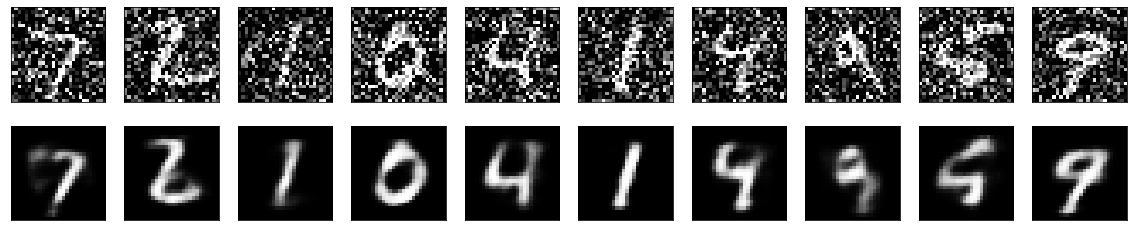

In [10]:
encoded_imgs = encoder_model.predict(x_test_noisy)
decoded_imgs = decoder_model.predict(encoded_imgs)
#decoded_imgs = vae.predict(x_test_noisy)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()